# (04) Align (within & across) -- perm

**Motivation**: Alignment scores (using permutation importance) within and across model classes. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# Code path
sys.path.insert(0, '/home/hadi/Documents/MTMST/code')
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Setup

In [2]:
path = pjoin(tmp_dir, 'trainer_analysis')

category = 'fixate1'
betas = [0.9, 1.0]

files = sorted([
    f for f in os.listdir(path) if category in f
    and any(f"beta-{b}" in f for b in betas)
])
print(files)

[
    'fixate1_nf-420_beta-0.9_(2023_05_07,05:51).npy',
    'fixate1_nf-420_beta-1.0_(2023_04_29,19:41).npy',
    'vanilla_fixate1_nf-420_beta-0.9_(2023_05_13,20:45).npy',
    'vanilla_fixate1_nf-420_beta-1.0_(2023_05_07,01:18).npy'
]

In [3]:
z_vld, z_tst = {}, {}

for f in files:
    x = pjoin(path, f)
    x = np.load(x, allow_pickle=True).item()
    z_vld[f] = x['data_vld']['z']
    z_tst[f] = x['data_tst']['z']

## Analyze

### Within class: cNVAE

In [4]:
f1 = 'fixate1_nf-420_beta-0.9_(2023_05_07,05:51).npy'
f2 = 'fixate1_nf-420_beta-1.0_(2023_04_29,19:41).npy'
x_vld, y_vld = z_vld[f1], z_vld[f2]
x_tst, y_tst = z_tst[f1], z_tst[f2]

In [5]:
shape = (y_vld.shape[1], x_vld.shape[1])
importances_mu = np.zeros(shape)
importances_sd = np.zeros(shape)

for i in tqdm(range(shape[0])):
    _lr = sk_linear.LinearRegression().fit(
        x_vld, y_vld[:, i])
    result = sk_inspect.permutation_importance(
        estimator=_lr,
        X=x_tst,
        y=y_tst[:, i],
        n_repeats=5,
        random_state=0,
    )
    importances_mu[i] = result.importances_mean
    importances_sd[i] = result.importances_std

#### Measure alignment

In [7]:
w = np.maximum(0, importances_mu)
w /= w.sum(1, keepdims=True)

a = 1 - entropy_normalized(w, axis=1)

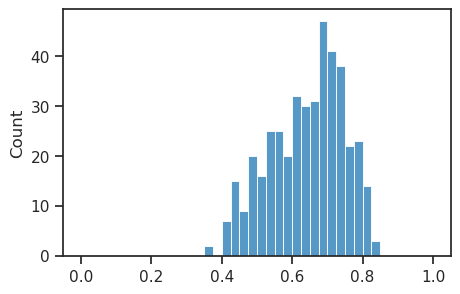

In [20]:
sns.histplot(a, bins=np.linspace(0, 1, 41));

In [21]:
np.mean(a), np.median(a)

(0.6408380610133132, 0.6594946730779686)

#### Measure r2

In [10]:
lr = sk_linear.LinearRegression().fit(z_vld[f1], z_vld[f2])
pred = lr.predict(z_tst[f1])

In [11]:
pred.shape

(75000, 420)

In [12]:
r = 1 - sp_dist.cdist(
    XA=pred.T,
    XB=z_tst[f2].T,
    metric='correlation',
)
r2 = sk_metric.r2_score(
    y_true=z_tst[f2],
    y_pred=pred,
    multioutput='raw_values',
)

In [13]:
r.shape, r2.shape

((420, 420), (420,))

In [14]:
r2.mean()

0.9018653902508128

<Axes: ylabel='Count'>

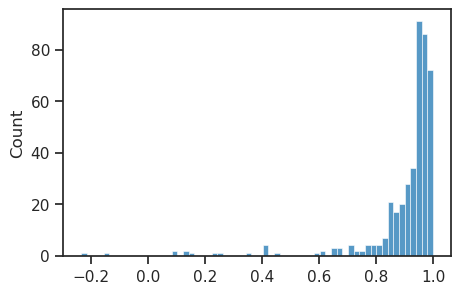

In [15]:
sns.histplot(r2);

### Within class: VAE

In [4]:
f1 = 'vanilla_fixate1_nf-420_beta-0.9_(2023_05_13,20:45).npy'
f2 = 'vanilla_fixate1_nf-420_beta-1.0_(2023_05_07,01:18).npy'
x_vld, y_vld = z_vld[f1], z_vld[f2]
x_tst, y_tst = z_tst[f1], z_tst[f2]

In [5]:
shape = (y_vld.shape[1], x_vld.shape[1])
importances_mu = np.zeros(shape)
importances_sd = np.zeros(shape)

for i in tqdm(range(shape[0])):
    _lr = sk_linear.LinearRegression().fit(
        x_vld, y_vld[:, i])
    result = sk_inspect.permutation_importance(
        estimator=_lr,
        X=x_tst,
        y=y_tst[:, i],
        n_repeats=5,
        random_state=0,
    )
    importances_mu[i] = result.importances_mean
    importances_sd[i] = result.importances_std

100%|███████████████████████████████████████| 420/420 [6:49:28<00:00, 58.50s/it]


#### TODO:

Test if ```result.importances_std``` is not so large, then just do ```n_repeats=1``` to save time

#### Measure alignment

In [6]:
w = np.maximum(0, importances_mu)
w /= w.sum(1, keepdims=True)

a = 1 - entropy_normalized(w, axis=1)

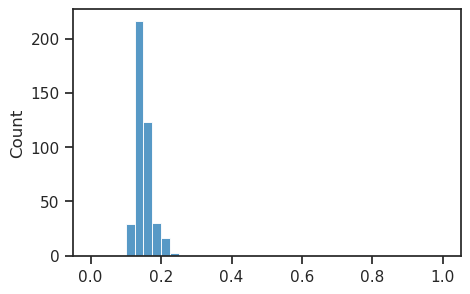

In [7]:
sns.histplot(a, bins=np.linspace(0, 1, 41));

In [8]:
np.mean(a), np.median(a)

(0.15495327456828287, 0.14554170922371545)

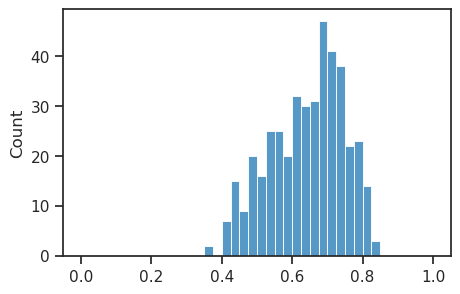

(0.6408380610133132, 0.6594946730779686)

#### Measure r2

In [9]:
lr = sk_linear.LinearRegression().fit(z_vld[f1], z_vld[f2])
pred = lr.predict(z_tst[f1])

In [10]:
pred.shape

(75000, 420)

In [11]:
r = 1 - sp_dist.cdist(
    XA=pred.T,
    XB=z_tst[f2].T,
    metric='correlation',
)
r2 = sk_metric.r2_score(
    y_true=z_tst[f2],
    y_pred=pred,
    multioutput='raw_values',
)

In [12]:
r.shape, r2.shape

((420, 420), (420,))

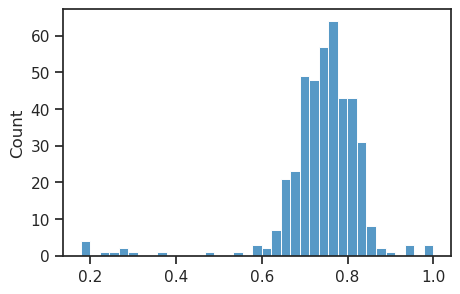

In [13]:
sns.histplot(r2);

In [14]:
r2.mean()

0.7395668822590681

0.9018653902508128

<Axes: ylabel='Count'>

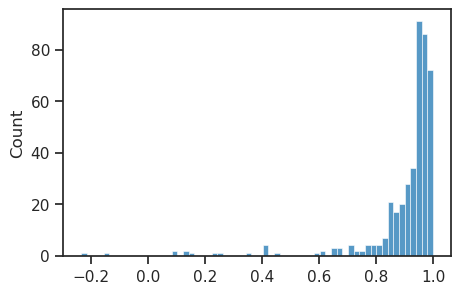

In [16]:
list(result)

['importances_mean', 'importances_std', 'importances']

In [17]:
result['importances'].shape

(420, 5)

In [24]:
result['importances'][6]

array([0.00477957, 0.00479909, 0.00502834, 0.00478505, 0.00483889])

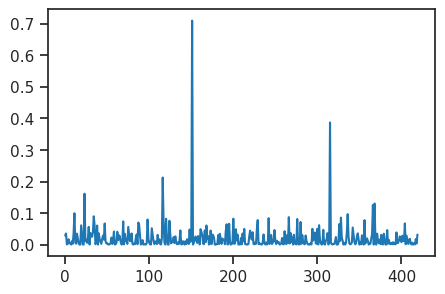

In [25]:
plt.plot(result['importances_mean'])

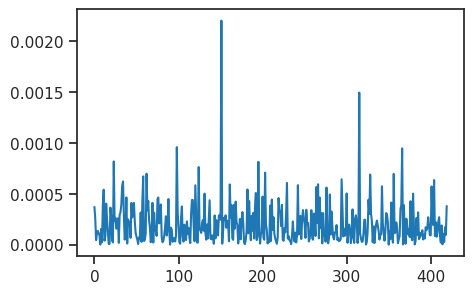

In [29]:
plt.plot(result['importances_std'])

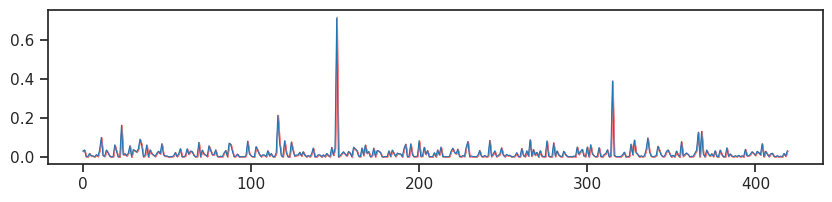

In [41]:
fig, ax = create_figure(1, 1, (10, 2))
intvl = range(420)
plt.plot(result['importances_mean'][intvl], lw=0.8)
plt.fill_between(
    x=intvl,
    y1=(result['importances_mean'] - 3 * result['importances_std'])[intvl],
    y2=(result['importances_mean'] + 3 * result['importances_std'])[intvl],
    color='r',
    alpha=0.5,
);